# Sharpe ratio optimisation with risk budgetting

The objective of this program is to maximise the sharpe ratio of the portfolio such that all stocks have a weight allocation of at least min_weight and a maximum weight allocation of 1. Moreover, each stock cannot have more than a x percentage contribution to the total portfolio volatility. 

The package scipy.optimize can only minimise the objective function. Hence, the negative Sharpe Ratio is minimised. 

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as dr
import pypfopt
from datetime import datetime
from pypfopt.efficient_frontier import EfficientFrontier
from scipy.optimize import minimize

In [116]:
rf = 0.0078
min_weight = 0.025
max_weight = 1
max_risk_contribution =0.10

# Monte carlo -> for comparison to the optimal portfolio
number_of_portfolios = 10000

In [104]:
# Initialize Input Data
start_date = '2017-01-01'
today = datetime.today().strftime('%Y-%m-%d')
assets = pd.read_excel ('SigmaInput.xlsx')["Ticker"]

# Create df for adjusted close prices of portfolio
prices = pd.DataFrame()

for stock in assets:
    prices[stock] = dr.data.get_data_yahoo(stock, start =start_date, end =today)['Adj Close']

#Show the daily simple return
return_stocks = (prices/prices.shift(1))-1
#return_stocks.to_excel('PortfolioReturns.xlsx')

In [105]:
cov_matrix = return_stocks.cov()*252 
cov_matrix_np = cov_matrix.to_numpy()
equally_weighted = [1/len(assets),]*len(assets)

In [106]:
# function to obtain portfolio- return,volatility,sharpe.
def get_p_data(weights):
        weights = np.array(weights)
        p_return= np.sum(return_stocks.mean()*weights) * 252
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(return_stocks.cov()*252, weights)))
        p_sharpe = (p_return-rf)/p_volatility 
        return np.array([p_return, p_volatility, p_sharpe])

def get_p_volatility(weights):
        weights = np.array(weights)
        p_volatility = np.sqrt(np.dot(weights.T, np.dot(return_stocks.cov()*252, weights)))
        return p_volatility

In [114]:
# function to get the marginal volatilities 
def marginal_volatilities(weights, cov_matrix_np):
    volatility_p = get_p_volatility(weights)
    print("portfolio volatility = ", volatility_p )
        
    for i in range(len(weights)):
        cov_weight_i = (weights[i] * np.dot(cov_matrix_np, weights)[i])/volatility_p 
        print("i = ", i , "risk contribution = ", cov_weight_i)

In [ ]:
# function to get negative Sharpe Ratio.
def negative_sharpe(weights):
        return get_p_data(weights)[2] * -1

# function to check if sum investment is 1.
def check_sum(weights):
        return np.sum(weights) -1

### Risk budgetting:

Let $w$ be the vector of the weight allocation and let $\Sigma$ be the covariance matrix. Then,

1. Portfolio volatility: $\sqrt(w\Sigma w^t)$
2. Risk contribution asset i: $w_i*\frac{(\Sigma w)_i}{\sqrt(w\Sigma w^t)}$

The following constraints needs to be included such that the individual risk contributions of each stock $i$ are below maximum contribution M:

$w_i*\frac{(\Sigma w)_i}{\sqrt(w\Sigma w^t)} \leq M\sqrt(w\Sigma w^t)$

Rewriting gives:

$M\sqrt(w\Sigma w^t) - w_i*\frac{(\Sigma w)_i}{\sqrt(w\Sigma w^t)} \geq 0$



In [107]:
# args is defined as the tuple of arguments with first the max risk contribution and then the covariance matrix
def risk_budget(weights, i, *args):
    volatility_p = get_p_volatility(weights)
    dot_product = np.dot(args[1], weights)
    dot_product_value = np.take(dot_product, i)
    q = args[0]*volatility_p - (weights[i]*dot_product_value/volatility_p)
    return q

In [108]:
# constraint for objective function-np
constraints_list = list()

#  sum investment is 1
constraints_list.append({'type':'eq', 'fun':check_sum})

# individual risk constributions
a = list(range(len(assets)))
for i in a:
    constraints_list.append({'type':'ineq', 'fun': risk_budget, 'args':(i, max_risk_contribution, cov_matrix_np)})  

constraints = tuple(constraints_list)

# weight boundaries
bounds = ((min_weight,max_weight),)*len(assets)

# equally weighted portfolio / starting point of Sequantial least Squares programming method.
equally_weighted = [1/len(assets),]*len(assets)

In [109]:
optimal_result = minimize(negative_sharpe, equally_weighted, method='SLSQP', bounds=bounds, constraints = constraints)
optimal_weights = optimal_result.x
optimal_portfolio = get_p_data(optimal_result.x)

optimal_return = np.round(optimal_portfolio[0],2)
optimal_volatility = np.round(optimal_portfolio[1],2)
optimal_sharpe = np.round(optimal_portfolio[2],2)
overview = pd.DataFrame({'Assets': assets,'Weight (%)': np.round(optimal_weights*100,2)}, columns=['Assets', 'Weight (%)']).T

statistic = ['Number of Assets', 'Expected Return', 'Expected Volatility', 'Expected Sharpe']
data = [np.round(len(assets),0), optimal_return, optimal_volatility, optimal_sharpe]
table = pd.DataFrame(data, statistic)

In [110]:
# Initialization of arrays we will use for n number of random portfolios. 
portfolio_returns = []
portfolio_sd = []
portfolio_sharpe = []
portfolio_weights = []

# Create n number of portfolios with random weights allocations and perform calculations for portfolio data. 
for portfolio in range (number_of_portfolios):
  
  # Generate random weights vector with lengts of number of assets
  weights = weights = max_weight * np.random.random_sample((len(assets))) + min_weight
  weights = weights / np.sum(weights)
  
  # Calculate annual return of the portfolio by summing over mean and weights. Annualize by multiplying by 252.
  annual_return = np.sum((return_stocks.mean() * weights) * 252)
  portfolio_returns.append(annual_return)
  
  # First calculate covariance matrix of the assets within the portfolio.
  cov_matrix_portfolio = (return_stocks.cov()) * 252
  
  # Calculate portfolio variance by formula and add the standard deviation to sd array for portfolios.
  portfolio_variance = np.dot(weights.T,np.dot(cov_matrix_portfolio, weights))
  portfolio_standard_deviation = np.sqrt(portfolio_variance) 
  portfolio_sd.append(portfolio_standard_deviation)
  
  # Calculate portfolio sharpe ratio and add the sharpe ratio to sharpe array of portfolios.
  sharpe_ratio = ((annual_return - rf)/portfolio_standard_deviation)
  portfolio_sharpe.append(sharpe_ratio)

  # Add random portfolio weights to weight array of portfolios.
  portfolio_weights.append(weights)

# Turn portfolio arrays into numpy arrays. 
portfolio_sd = np.array(portfolio_sd)
portfolio_returns = np.array(portfolio_returns)
portfolio_sharpe = np.array(portfolio_sharpe)


                 0      1     2     3       4      5    6       7    8  \
Assets      HEN.DE  AD.AS   JPM    MA  ALV.DE    NVO  MDT  DPW.DE  MGA   
Weight (%)     2.5  16.63  6.17  6.94     2.5  11.61  2.5     2.5  2.5   

                 9    10    11       12    13    14     15    16  
Assets      DTE.DE  NFLX   ETN  PHIA.AS  NVDA    WM  NTDOY   UNH  
Weight (%)     2.5  7.49  4.39    11.52  5.18  2.63   9.91  2.53  
                         0
Number of Assets     17.00
Expected Return       0.25
Expected Volatility   0.17
Expected Sharpe       1.41


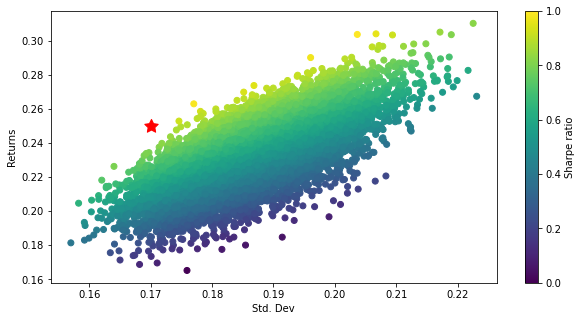

In [112]:
# Create a scatter plot of portfolio performances to display output
plt.figure(figsize=(10, 5))
plt.scatter(portfolio_sd, portfolio_returns, c=portfolio_returns / portfolio_sd)
plt.scatter(optimal_volatility, optimal_return, s=200, c='red', marker=(5, 1))
plt.xlabel('Std. Dev')
plt.ylabel('Returns')
plt.colorbar(label='Sharpe ratio')
print(overview)
print(table)

In [113]:
marginal_volatilities(optimal_weights, cov_matrix_np)

portfolio volatility =  0.16975389066926136
i =  0 risk contribution =  0.002582546389376871
i =  1 risk contribution =  0.013635367754200626
i =  2 risk contribution =  0.01309477365667924
i =  3 risk contribution =  0.016975377668897867
i =  4 risk contribution =  0.003665669572030867
i =  5 risk contribution =  0.01697537835484569
i =  6 risk contribution =  0.004227299767167626
i =  7 risk contribution =  0.004017769344796034
i =  8 risk contribution =  0.005902833628739801
i =  9 risk contribution =  0.0025462692950668168
i =  10 risk contribution =  0.016975378379041225
i =  11 risk contribution =  0.009811060543721703
i =  12 risk contribution =  0.016975378438249495
i =  13 risk contribution =  0.01697537827077875
i =  14 risk contribution =  0.0034591264645602374
i =  15 risk contribution =  0.01697537853831332
i =  16 risk contribution =  0.0049589046027951654
